# Orbital Elements

**Note:  All angles for orbital elements are in radians**

We can add particles to a simulation by specifying cartesian components:

In [1]:
import rebound
sim = rebound.Simulation()
sim.add(m=1., x=1., vz = 2.)

Any components not passed automatically default to 0.  REBOUND can also accept orbital elements.  

**Reference bodies**

As a reminder, there is a one-to-one mapping between (x,y,z,vx,vy,vz) and orbital elements, and one should always specify what the orbital elements are referenced against (e.g., the central star, the system's barycenter, etc.).  The differences between orbital elements referenced to these centers differ by $\sim$ the mass ratio of the largest body to the central mass.  By default, REBOUND always uses Jacobi elements, which for each particle are always referenced to the center of mass of all particles with lower index in the simulation. 

For the painstaking user: When separating out the center of mass degree of freedom and reducing the N body problem to N-1 Kepler problems and interaction terms, there are a number of possible Hamiltonian splittings (see e.g., Hernandez & Dehnen 2017), and different possible choices for the primary mass in each of the separate Kepler problems. REBOUND takes this primary mass to be the total mass of all the particles in the simulation. If particles are added from the inside out, this gives logical behavior in the limit of a hierarchical system, even for large masses (one can think of it as setting up our new particle in a 2-body orbit around all the interior mass concentrated at the interior particles' center of mass). 

Let's set up a stellar binary,

In [2]:
sim.add(m=1., a=1.)
sim.status(showAllFields=False)

---------------------------------
REBOUND version:     	3.28.4
REBOUND built on:    	Oct 31 2023 11:59:30
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x102f92f40, m=1.0 x=1.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=2.0>
<rebound.particle.Particle object at 0x1030f0040, m=1.0 x=2.0 y=0.0 z=0.0 vx=0.0 vy=1.4142135623730951 vz=2.0>
---------------------------------


We always have to pass a semimajor axis (to set a length scale), but any other elements are by default set to 0.  Notice that our second star has the same vz as the first one due to the default Jacobi elements.  Now we could add a distant planet on a circular orbit,

In [3]:
sim.add(m=1.e-3, a=100.)

This planet is set up relative to the binary center of mass (again due to the Jacobi coordinates), which is probably what we want.  But imagine we now want to place a test mass in a tight orbit around the second star.  If we passed things as above, the orbital elements would be referenced to the binary/outer-planet center of mass.  We can override the default by explicitly passing a primary (any instance of the Particle class):

In [4]:
sim.add(primary=sim.particles[1], a=0.01)

All simulations are performed in Cartesian elements, so to avoid the overhead, REBOUND does not update particles' orbital elements as the simulation progresses.  However, you can always access any orbital element through, e.g., `sim.particles[1].inc` (see the diagram, and table of orbital elements under the Orbit structure at httsp://rebound.readthedocs.org/en/latest/python_api.html).  This will calculate that orbital element individually--you can calculate all the particles' orbital elements at once with `sim.orbits()`.  REBOUND will always output angles in the range $[-\pi,\pi]$, except the inclination which is always in $[0,\pi]$.

In [5]:
print(sim.particles[1].a)
orbits = sim.orbits()
for orbit in orbits:
    print(orbit)

1.0000000000000002
<rebound.Orbit instance, a=1.0000000000000002 e=2.220446049250313e-16 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=100.0000000000001 e=1.0403139286217734e-15 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=-0.018887854728438246 e=25.355597505396737 inc=0.0 Omega=0.0 omega=0.0 f=0.0>


Notice that there is always one less orbit than there are particles, since orbits are only defined between pairs of particles.  We see that we got the first two orbits right, but the last one is way off.  The reason is that again the REBOUND default is that we always get Jacobi elements.  But we initialized the last particle relative to the second star, rather than the center of mass of all the previous particles.

To get orbital elements relative to a specific body, you can manually use the `orbit` method of the Particle class:

In [6]:
print(sim.particles[3].orbit(primary=sim.particles[1]))

<rebound.Orbit instance, a=0.009999999999999573 e=2.131628207280255e-14 inc=0.0 Omega=0.0 omega=3.141592653589793 f=3.141592653589793>


though we could have simply avoided this problem by adding bodies from the inside out (second star, test mass, first star, circumbinary planet).

When you access orbital elements individually, e.g., `sim.particles[1].inc`, you always get Jacobi elements.  If you need to specify the primary, you have to do it with `sim.orbit()` as above.

**Edge cases and orbital element sets**

Different orbital elements lose meaning in various limits, e.g., a planar orbit and a circular orbit.  REBOUND therefore allows initialization with several different types of variables that are appropriate in different cases.  It's important to keep in mind that the procedure to initialize particles from orbital elements is not exactly invertible, so one can expect discrepant results for elements that become ill-defined.  For example, 

In [7]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0., inc=0.1, Omega=0.3, omega=0.1)
print(sim.particles[1].orbit)

<bound method Particle.orbit of <rebound.particle.Particle object at 0x1030f01c0, m=0.0 x=0.9212083850751501 y=0.38894186704119954 z=0.009966711079379185 vx=-0.38794934790022223 vy=0.9163121344357245 vz=0.09933466539753062>>


The problem here is that $\omega$ (the angle from the ascending node to pericenter) is ill-defined for a circular orbit, so it's not clear what we mean when we pass it, and we get spurious results for both $\omega$ and $f$, since the latter is also undefined as the angle from pericenter to the particle's position.  However, the true longitude $\theta$, the broken angle from the $x$ axis to the ascending node = $\Omega + \omega + f$, and then to the particle's position, is always well-defined:  

In [8]:
print(sim.particles[1].theta)

0.40000000000000036


To be clearer and ensure we get the results we expect, we could instead pass theta to specify the longitude we want, e.g.

In [9]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0., inc=0.1, Omega=0.3, theta = 0.4)
print(sim.particles[1].theta)

0.3999999999999986


In [10]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0.2, Omega=0.1)
print(sim.particles[1].orbit)

<bound method Particle.orbit of <rebound.particle.Particle object at 0x1030f0b40, m=0.0 x=0.7960033322224207 y=0.07986673331746252 z=0.0 vx=-0.12227046503170248 vy=1.2186262484375312 vz=0.0>>


Here we have a planar orbit, in which case the line of nodes becomes ill-defined, so $\Omega$ is not a good variable, but we pass it anyway!  In this case, $\omega$ is also undefined since it is referenced to the ascending node.  Here we get that now these two ill-defined variables get flipped.  The appropriate variable is pomega ($\varpi = \Omega + \omega$), which is the angle from the $x$ axis to pericenter:

In [11]:
print(sim.particles[1].pomega)

0.10000000000000057


We can specify the pericenter of the orbit with either $\omega$ or $\varpi$:

In [12]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0.2, pomega=0.1)
print(sim.particles[1].orbit)

<bound method Particle.orbit of <rebound.particle.Particle object at 0x1030f05c0, m=0.0 x=0.7960033322224207 y=0.07986673331746252 z=0.0 vx=-0.12227046503170248 vy=1.2186262484375312 vz=0.0>>


Note that if the inclination is exactly zero, REBOUND sets $\Omega$ (which is undefined) to 0, so $\omega = \varpi$.  

Finally, we can specify the position of the particle along its orbit using mean (rather than true) longitudes or anomalies (for example, this might be useful for  resonances).  We can either use the mean anomaly $M$, which is referenced to pericenter (again ill-defined for circular orbits), or its better-defined counterpart the mean longitude `l` $= \lambda = \Omega + \omega + M$, which is analogous to $\theta$ above,

In [13]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0.1, Omega=0.3, M = 0.1)
sim.add(a=1., Omega=0.3, l = 0.4)
print(sim.particles[1].l)
print(sim.particles[2].l)

0.4000000000000039
0.39999999999999947


REBOUND calculates the mean longitude in such a way that it smoothly approaches $\theta$ in the limit of $e\rightarrow0$:

In [14]:
sim.particles[2].theta

0.39999999999999947

In summary, you can specify the phase of the orbit through any one of the angles `M`, `f`, `theta` or `l`=$\lambda$.  Additionally, one can instead use the time of pericenter passage `T`.  This time should be set in the appropriate time units, and you'd initialize `sim.t` to the appropriate time you want to start the simulation.

**Accuracy**

As a test of accuracy and demonstration of issues related to the last section, let's test the numerical stability by initializing particles with small eccentricities and true anomalies, computing their orbital elements back, and comparing the relative error.  We choose the inclination and node longitude randomly:

In [16]:
import random
import numpy as np

def simulation(par):
    e,f = par
    e = 10**e
    f = 10**f
    sim = rebound.Simulation()
    sim.add(m=1.)
    a = 1.
    inc = random.random()*np.pi
    Omega = random.random()*2*np.pi
    sim.add(m=0.,a=a,e=e,inc=inc,Omega=Omega, f=f)
    o=sim.particles[1].orbit()
    if o.f < 0: # avoid wrapping issues
        o.f += 2*np.pi
    err = max(np.fabs(o.e-e)/e, np.fabs(o.f-f)/f)
    return err

We will use the multiprocess module to run the computation in parallel. If the following line throws you an ImportError, install the module with `pip install multiprocess`.

In [17]:
from multiprocess import Pool

In [18]:
random.seed(1)
N = 100
es = np.linspace(-16.,-1.,N)
fs = np.linspace(-16.,-1.,N)
params = [(e,f) for e in es for f in fs]
with Pool() as pool:
    res = pool.map(simulation, params)
    res = np.array(res).reshape(N,N)
    res = np.nan_to_num(res)

Let's plot the results.

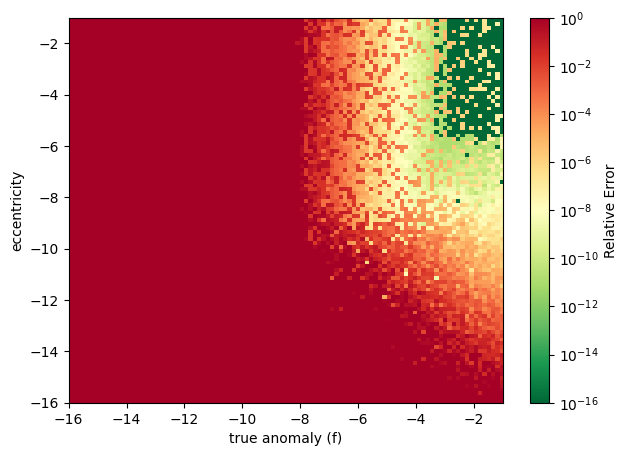

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
import matplotlib

f,ax = plt.subplots(1,1,figsize=(7,5))
extent=[fs.min(), fs.max(), es.min(), es.max()]

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel(r"true anomaly (f)")
ax.set_ylabel(r"eccentricity")

im = ax.imshow(res, norm=LogNorm(vmax=1., vmin=1.e-16), aspect='auto', origin="lower", interpolation='nearest', cmap="RdYlGn_r", extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.solids.set_rasterized(True)
cb.set_label("Relative Error")

We see that the behavior is poor, which is physically due to $f$ becoming poorly defined at low $e$.  If instead we initialize the orbits with the true longitude $\theta$ as discussed above, we get much better results:

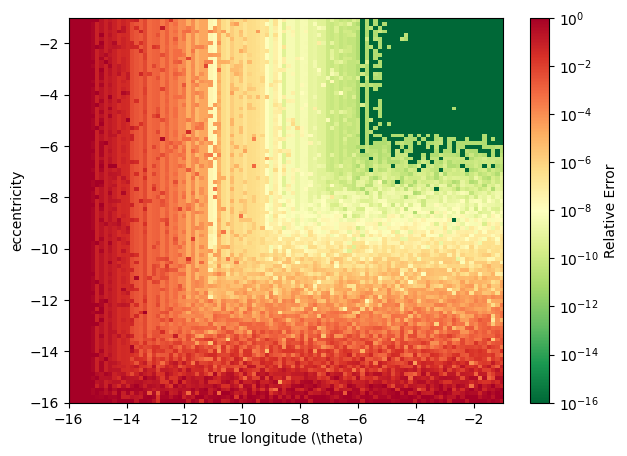

In [20]:
def simulation(par):
    e,theta = par
    e = 10**e
    theta = 10**theta
    sim = rebound.Simulation()
    sim.add(m=1.)
    a = 1.
    inc = random.random()*np.pi
    Omega = random.random()*2*np.pi
    omega = random.random()*2*np.pi
    sim.add(m=0.,a=a,e=e,inc=inc,Omega=Omega, theta=theta)
    o=sim.particles[1].orbit()
    if o.theta < 0:
        o.theta += 2*np.pi
    err = max(np.fabs(o.e-e)/e, np.fabs(o.theta-theta)/theta)
    return err

random.seed(1)
N = 100
es = np.linspace(-16.,-1.,N)
thetas = np.linspace(-16.,-1.,N)
params = [(e,theta) for e in es for theta in thetas]

with Pool() as pool:
    res = pool.map(simulation, params)
    res = np.array(res).reshape(N,N)
    res = np.nan_to_num(res)

f,ax = plt.subplots(1,1,figsize=(7,5))
extent=[thetas.min(), thetas.max(), es.min(), es.max()]

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel(r"true longitude (\theta)")
ax.set_ylabel(r"eccentricity")

im = ax.imshow(res, norm=LogNorm(vmax=1., vmin=1.e-16), aspect='auto', origin="lower", interpolation='nearest', cmap="RdYlGn_r", extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.solids.set_rasterized(True)
cb.set_label("Relative Error")

**Hyperbolic & Parabolic Orbits**

REBOUND can also handle hyperbolic orbits, which have negative $a$ and $e>1$:

In [21]:
sim.add(a=-0.2, e=1.4)
sim.status()

---------------------------------
REBOUND version:     	3.28.4
REBOUND built on:    	Oct 31 2023 11:59:30
Number of particles: 	4
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x10714f740, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x10714f940, m=0.0 x=0.821318061318507 y=0.3695219671870099 z=0.0 vx=-0.44206687767576147 vy=1.0125602418928732 vz=0.0>
<rebound.particle.Particle object at 0x10714f740, m=0.0 x=0.9210609940028852 y=0.38941834230865013 z=0.0 vx=-0.38941834230865013 vy=0.9210609940028852 vz=0.0>
<rebound.particle.Particle object at 0x10714f940, m=0.0 x=0.07999999999999999 y=0.0 z=0.0 vx=0.0 vy=5.477225575051662 vz=0.0>
---------------------------------
The following fields have non-default values:
N:
< 0
---
> 4
rand_seed:
< 764174
---
> 888644
particles:
> (512 bytes, values not printed)



Currently there is no support for exactly parabolic orbits, but we can get a close approximation by passing a nearby hyperbolic orbit where we can specify the pericenter = $|a|(e-1)$ with $a$ and $e$.  For example, for a 0.1 AU pericenter,

In [22]:
sim = rebound.Simulation()
sim.add(m=1.)
q = 0.1
a=-1.e14
e=1.+q/np.fabs(a)
sim.add(a=a, e=e)
print(sim.particles[1].orbit)

<bound method Particle.orbit of <rebound.particle.Particle object at 0x10714f640, m=0.0 x=0.1110223024625156 y=0.0 z=0.0 vx=0.0 vy=4.244337228529561 vz=0.0>>


**Retrograde Orbits**

Orbital elements can be counterintuitive for retrograde orbits, but REBOUND tries to sort them out consistently.  This can lead to some initially surprising results.  For example,

In [23]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1.,inc=np.pi,e=0.1, Omega=0., pomega=1.)
print(sim.particles[1].orbit)

<bound method Particle.orbit of <rebound.particle.Particle object at 0x10714f940, m=0.0 x=0.48627207528132577 y=0.7573238863271068 z=-9.274542733083253e-17 vx=0.9302811761928806 vy=-0.5973266739761528 vz=7.315141993302302e-17>>


We passed $\Omega=0$ and $\varpi=1.$.  For prograde orbits, $\varpi = \Omega + \omega$, so we'd expect $\omega = 1$, but instead we get $\omega=-1$.  If we think about things physically, $\varpi$ is the angle from the $x$ axis to pericenter, measured in the positive direction (counterclockwise) defined by $z$.  $\Omega$ is always measured in this same sense, but $\omega$ is always measured in the orbital plane *in the direction of the orbit*.  For retrograde orbits, this means that $\omega$ is measured in the opposite sense to $\Omega$, so $\varpi = \Omega - \omega$, which is why we got $\omega = -1$. 

Similarly, the retrograde version of $\theta = \Omega + \omega + f$ is $\theta = \Omega - \omega - f$, and `l` = $\lambda = \Omega + \omega + M$ becomes $\lambda = \Omega - \omega - M$.  REBOUND chooses these conventions based on whether $i < \pi/2$, which means that if you were tracking $\varpi$ for nearly polar orbits, you would get unphysical jumps if the orbits crossed back and forth between prograde and retrograde.  Of course, $\varpi$ is not a good angle at such high inclinations, and only has physical meaning when the orbital plane nearly coincides with the reference plane.

**Exceptions**

Adding a particle or getting orbital elements from particles in a simulation should never yield NaNs in any of the structure fields.  Please let us know if you find a case that does.  

In cases where it would return a `NaN`, `REBOUND` will raise a `ValueError`.  The only cases that should do so when adding a particle are 1) passing an eccentricity of exactly 1. 2) passing a negative eccentricity. 3) Passing $e>1$ if $a>0$. 4) Passing $e<1$ if $a<0$. 5) Passing a longitude or anomaly for a hyperbolic orbit that's beyond the range allowed by the asymptotes defined by the hyperbola.  You will also get errors if you try to initialize particles with orbital elements manually with `rebound.Particle()`.

When obtaining orbital elements from a `Particle` structure, REBOUND will raise a `ValueError` if 1) the primary's mass is zero, or 2) the particle's and primary's position are the same.

**Negative inclinations**

While inclinations are only defined in the range $[0,\pi]$, you can also pass negative inclinations when adding particles in REBOUND.  This is interpreted as referencing $\Omega$ and $\omega$ to the **descending**, rather than the ascending node.  So for example, if one set up particles with the same $\Omega$ and a range of inclinations distributed around zero, one would obtain what one might expect, i.e. a set of orbits that are all rotated around the same line of nodes.

**Jacobi masses**

There is a classical Hamiltonian splitting for the N-body problem (see e.g., Wisdom & Holman 1991) that when expanded to first order in the planet/star mass ratio, gives an interaction Hamiltonian with the same form as the disturbing function for an exterior perturber. This makes it particularly attractive for analytic or semi-analytic studies. In this splitting, the masses of the primaries for each planet take on a particular form. One can add particles using these jacobi masses with the `jacobi_masses` flag. By default, this flag is false and the primary mass is the total mass of all particles in the simulation (see the top of this notebook).

In [24]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-3, a=1., jacobi_masses=True)
sim.add(m=1.e-3, a=5., jacobi_masses=True)
sim.move_to_com()

The jacobi mass and default mass assigned by REBOUND always agree for the first particle, but differ for all the rest

In [25]:
print(sim.particles[1].a, sim.particles[2].a)

1.0 4.995009980039918


We can calculate orbital elements using jacobi masses by using the same flag in `sim.orbits`

In [26]:
o = sim.orbits(jacobi_masses=True)
print(o[0].a, o[1].a)

1.0 4.999999999999999
